In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import ast
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
#sns.set_palette(palette="RdBu")
sns.set_palette(palette="gnuplot2")

doc = pd.read_csv('kyc_data/doc_reports.csv', index_col = 0)
fsr = pd.read_csv('kyc_data/facial_similarity_reports.csv', index_col = 0)

### "The pass rate has decreased substantially in the recent period"

Let's find out how much it has been decreasing, and since when:

In [2]:
#Parsing datetime data -----------------------------------------------------------------------------------------------------------------------
fsr['created_at'] = pd.to_datetime(fsr['created_at'], format = '%Y-%m-%dT%H:%M:%SZ')
fsr['Created_Day'] = fsr['created_at'].dt.date

doc['created_at'] = pd.to_datetime(doc['created_at'], format = '%Y-%m-%dT%H:%M:%SZ')
doc['Created_Day'] = doc['created_at'].dt.date

# Merging dataframes --------------------------------------------------------------------------------------------------------------------------
# Dates may differ accross dataframes, for the same attempt id - but only by one second at most, therefore we will consider they are the same
df = doc[['attempt_id', 'user_id', 'result', 'created_at']].merge(fsr[['attempt_id', 'result']], how = 'inner', on = 'attempt_id')
df = df.rename(columns = {'result_x': 'result_doc', 'result_y': 'result_fsr'})

df = df[['attempt_id', 'user_id', 'created_at', 'result_doc', 'result_fsr']]

df['UltimateResult'] = np.where((df['result_doc'] == 'clear') & (df['result_fsr'] == 'clear'), 'clear', 'consider')
                  
df.head()

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult
0,050a0596de424fab83c433eaa18b3f8d,ab23fae164e34af0a1ad1423ce9fd9f0,2017-06-20 23:12:57,consider,clear,consider
1,f69c1e5f45a64e50a26740b9bfb978b7,15a84e8951254011b47412fa4e8f65b8,2017-06-20 23:16:04,clear,clear,clear
2,f9f84f3055714d8e8f7419dc984d1769,ffb82fda52b041e4b9af9cb4ef298c85,2017-06-20 17:59:49,clear,clear,clear
3,10a54a1ecf794404be959e030f11fef6,bd4a8b3e3601427e88aa1d9eab9f4290,2017-06-20 17:59:38,clear,clear,clear
4,1f320d1d07de493292b7e0d5ebfb1cb9,f52ad1c7e69543a9940c3e7f8ed28a39,2017-06-20 18:08:09,clear,clear,clear


In [3]:
print("There are", \
      str(df.duplicated(subset=df.columns.difference(['attempt_id']), keep='first').sum()), \
      "total duplicate attempts (different attemptID's but same records, including datetimes)")

There are 4512 total duplicate attempts (different attemptID's but same records, including datetimes)


This may happen for a multitude of reasons, including ETL bugs, but for computing the pass rate, these duplicated results are irrelevant and may be removed.

In [4]:
# Removing duplicates
df = df.drop_duplicates(subset=df.columns.difference(['attempt_id']))
df.sort_values(by = 'created_at', inplace = True)
df.head()

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult
47692,d21de828c5514277aaedb316edc6c48c,3aee7324dfba466d96888ff9ad185b58,2017-05-23 15:13:02,clear,clear,clear
25636,b92d851b2380442cbe373c33f1c9dc44,206b6bd0cc114844b471fb750e1c9b8c,2017-05-23 15:18:05,clear,consider,consider
53960,b21d5797e8864adbb215182218094cfb,8edd77f60f8e4a739f35cb797b292e6d,2017-05-23 15:22:16,clear,consider,consider
25637,63485edd8dca4d25b95d1dd4484b3bd6,636fb441d54446a8996e3ff79e09535f,2017-05-23 15:27:06,consider,clear,consider
25638,c991888dc7c044f2bfdfe058c3aaa45d,fffa227d01064f9f9cef396d893863c1,2017-05-23 15:27:56,clear,clear,clear


#### We were told that each customer has up to 2 attempts, so let's find out if there's any customer with more than 2 records:

In [5]:
df.describe()

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult
count,171891,171891,171891,171891,171890,171891
unique,171891,142723,169809,2,2,2
top,955bd94f8b1149728c72e12722488b79,abe6afc009da4cb283bd5f270d8c5288,2017-06-26 18:19:31,clear,clear,clear
freq,1,5,3,129066,161274,123706
first,NaN,NaN,2017-05-23 15:13:02,NaN,NaN,NaN
last,NaN,NaN,2017-10-31 23:54:24,NaN,NaN,NaN


In [6]:
print('Number of people with more than 2 attempts: ', str((df['user_id'].value_counts() > 2).sum()))

Number of people with more than 2 attempts:  264


Checking the user with the most records:

In [7]:
df[df['user_id'] == 'abe6afc009da4cb283bd5f270d8c5288']

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult
160418,a03f789c696f4a21899d3d167aaddfc0,abe6afc009da4cb283bd5f270d8c5288,2017-07-20 20:32:10,clear,clear,clear
160429,33fb86bacf754d2cad8fdcee269e4268,abe6afc009da4cb283bd5f270d8c5288,2017-07-20 20:40:32,clear,clear,clear
123184,1b502732cb40464d855fb25165523fe0,abe6afc009da4cb283bd5f270d8c5288,2017-08-31 12:22:33,consider,clear,consider
98322,979f5a7cec214b6aa2bdf4356f5aaeba,abe6afc009da4cb283bd5f270d8c5288,2017-09-20 21:04:47,clear,clear,clear
96806,9f923045ca4140acb749c40fc34f5e6e,abe6afc009da4cb283bd5f270d8c5288,2017-09-22 07:08:46,clear,clear,clear


Alright, the user has 5 attempts, but at most 2 attempts in the same day. Maybe each customer has up to 2 attempts PER DAY?

In [8]:
df['Date'] = df['created_at'].dt.date
df2 = df.groupby(['Date', 'user_id']).count()['result_doc'].reset_index()
df2[df2['result_doc'] > 2].head()

,Date,user_id,result_doc
431,2017-05-26,07857065dfa64db386739ec4fff47856,3
1453,2017-05-31,7ffbcb0dcb8d4c1489687c38a13a66ba,3
1468,2017-05-31,9169edf362594ad1a212e5d78cfafa2e,3
1675,2017-06-01,783357724d2a4536a877a0cc694da51b,3
1905,2017-06-02,dd0e995abb89417199e8a65d0120d5b4,3


Well, not even that. Some users have 3 records in some specific dates. Let's dive into one of them:

In [9]:
df.loc[df['user_id'] == 'dd0e995abb89417199e8a65d0120d5b4']

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult,Date
27476,03edaaeb94ab47be91eeaeef391933d1,dd0e995abb89417199e8a65d0120d5b4,2017-06-02 07:11:26,clear,consider,consider,2017-06-02
27489,f22ef055cc274c7b8d6909980993ce81,dd0e995abb89417199e8a65d0120d5b4,2017-06-02 08:05:44,clear,consider,consider,2017-06-02
27490,cfc0bd770782463b807795c4efaa755d,dd0e995abb89417199e8a65d0120d5b4,2017-06-02 08:08:19,clear,consider,consider,2017-06-02


In [10]:
df.loc[df['user_id'] == '07857065dfa64db386739ec4fff47856']

,attempt_id,user_id,created_at,result_doc,result_fsr,UltimateResult,Date
26217,e4b26d4ddda545c9931a0a845cd65109,07857065dfa64db386739ec4fff47856,2017-05-26 19:00:35,consider,clear,consider,2017-05-26
26218,0f1533273e7444bc86869caabfc360da,07857065dfa64db386739ec4fff47856,2017-05-26 19:05:54,consider,clear,consider,2017-05-26
26221,080116e9a61c4f27bd3a05684a19f31a,07857065dfa64db386739ec4fff47856,2017-05-26 19:18:15,consider,clear,consider,2017-05-26


It may have something to do with the fact that only one validation fails, for all these customers.

### Since we have no further info on that, and we want to compute a Pass Rate, a workaround is to compute a **daily Pass Rate**:

For this, if we drop the duplicates of each category (clear and consider) for all dataframes (document check, facial similarity and the merge between both), **we will have at most one 'clear' and one 'consider' per day, per user**. We are then able to compute a daily pass rate without further assumptions, which will from here be named **ultimate pass rate**.

Moreover, Document and Facial Similarity tests Pass Rates may also be computed, for further deep diving:

In [11]:
#Pass Rate of Doc
df_doc = df[['attempt_id', 'user_id', 'created_at', 'result_doc', 'Date']]

df_doc_clear = df_doc.copy()
df_doc_clear = df_doc_clear[df_doc_clear['result_doc'] == 'clear']
df_doc_clear = df_doc_clear.drop_duplicates(subset=df_doc_clear.columns.difference(['attempt_id', 'created_at']))

df_doc_notclear = df_doc.copy()
df_doc_notclear = df_doc_notclear[df_doc_notclear['result_doc'] != 'clear']
df_doc_notclear = df_doc_notclear.drop_duplicates(subset=df_doc_notclear.columns.difference(['attempt_id', 'created_at']))

df_doc2 = df_doc_clear.append(df_doc_notclear, ignore_index = True)

df_doc2 = df_doc2.groupby(['Date', 'result_doc']).size().unstack(fill_value=0).reset_index()
df_doc2['PassRate_doc'] = df_doc2['clear'] / (df_doc2['clear'] + df_doc2['consider'])
df_doc2['PassRate_doc_7day_Average'] = df_doc2['PassRate_doc'].rolling(7).mean().shift(-3)


#Pass Rate of FSR
df_fsr = df[['attempt_id', 'user_id', 'created_at', 'result_fsr', 'Date']]

df_fsr_clear = df_fsr.copy()
df_fsr_clear = df_fsr_clear[df_fsr_clear['result_fsr'] == 'clear']
df_fsr_clear = df_fsr_clear.drop_duplicates(subset=df_fsr_clear.columns.difference(['attempt_id', 'created_at']))

df_fsr_notclear = df_fsr.copy()
df_fsr_notclear = df_fsr_notclear[df_fsr_notclear['result_fsr'] != 'clear']
df_fsr_notclear = df_fsr_notclear.drop_duplicates(subset=df_fsr_notclear.columns.difference(['attempt_id', 'created_at']))

df_fsr2 = df_fsr_clear.append(df_fsr_notclear, ignore_index = True)

df_fsr2 = df_fsr2.groupby(['Date', 'result_fsr']).size().unstack(fill_value=0).reset_index()
df_fsr2['PassRate_fsr'] = df_fsr2['clear'] / (df_fsr2['clear'] + df_fsr2['consider'])
df_fsr2['PassRate_fsr_7day_Average'] = df_fsr2['PassRate_fsr'].rolling(7).mean().shift(-3)

# Total Pass Rate
df_clear = df.copy()
df_clear = df_clear[df_clear['UltimateResult'] == 'clear']
df_clear = df_clear.drop_duplicates(subset=df_clear.columns.difference(['attempt_id', 'created_at']))

df_notclear = df.copy()
df_notclear = df_notclear[df_notclear['UltimateResult'] != 'clear']
df_notclear = df_notclear.drop_duplicates(subset=df_notclear.columns.difference(['attempt_id', 'created_at']))

df2 = df_clear.append(df_notclear, ignore_index = True)

df2 = df2.groupby(['Date', 'UltimateResult']).size().unstack(fill_value=0).reset_index()
df2['PassRate'] = df2['clear'] / (df2['clear'] + df2['consider'])
df2['PassRate_7day_Average'] = df2['PassRate'].rolling(7).mean().shift(-3)

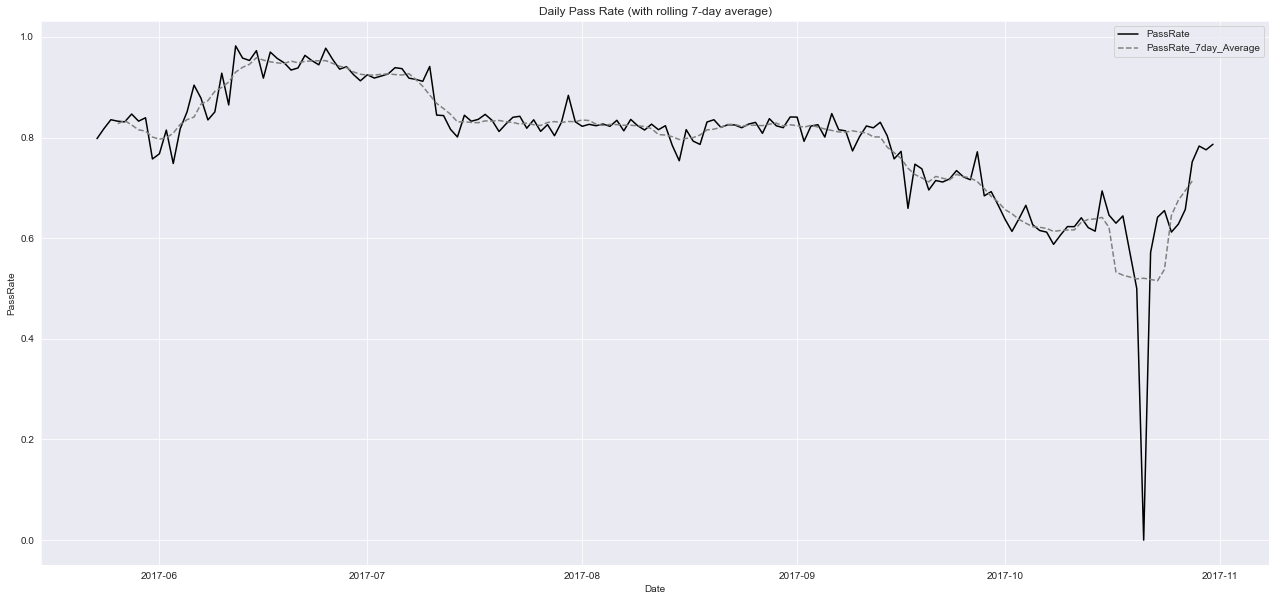

In [12]:
fig = plt.figure(figsize = (22,10))

sns.lineplot(x = df2['Date'], y = df2['PassRate'], label = 'PassRate', color = 'black')
sns.lineplot(x = df2['Date'], y = df2['PassRate_7day_Average'], label = 'PassRate_7day_Average', color = 'grey', linestyle='--')

plt.legend()
plt.title('Daily Pass Rate (with rolling 7-day average)')
plt.show()

* We can easily confirm that, while he Daily Pass Rate had been very high for a while, it **decreased rather quickly around mid July**, stabilised, and then **went down again, starting mid september**.

* It **dropped enormously to almost zero in the final days of October**, only to recover to the same numbers before the spike. It may be further investigated to assess why it happened, but for now it's enough to focus on the previous two main drops.

First of all, we need to check the contribution of each test (Document + Facial Similarity) to the ultimate result:

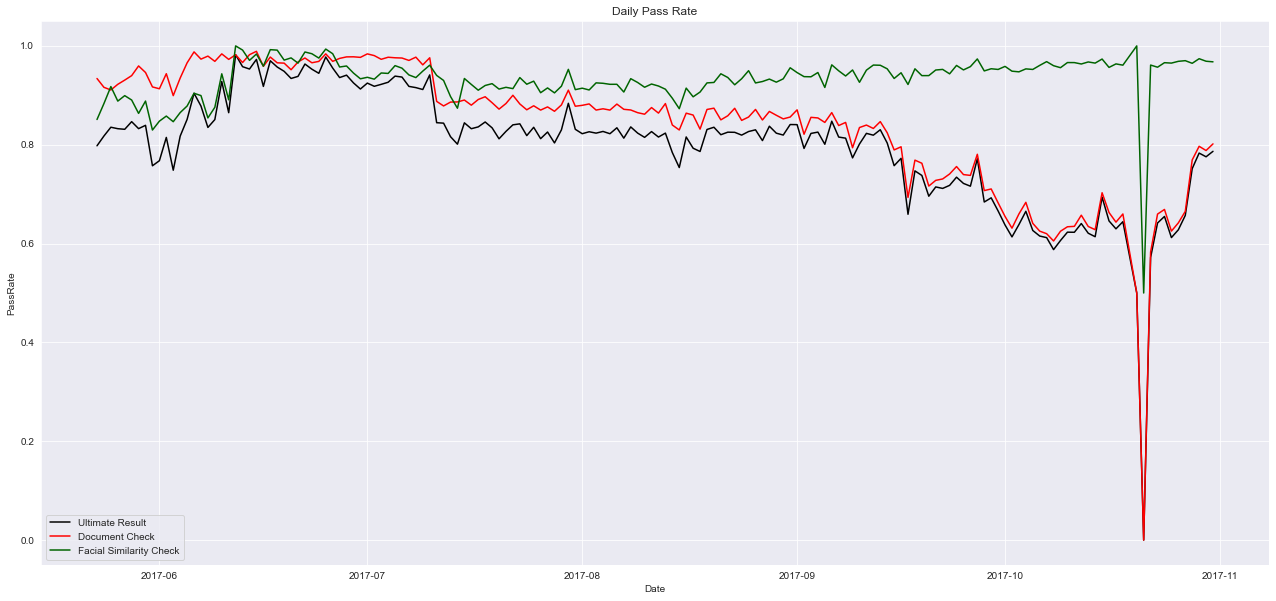

In [13]:
fig = plt.figure(figsize = (22,10))

sns.lineplot(x = df2['Date'], y = df2['PassRate'], label = 'Ultimate Result', color = 'black')
sns.lineplot(x = df_doc2['Date'], y = df_doc2['PassRate_doc'], label = 'Document Check', color = 'red')
sns.lineplot(x = df_fsr2['Date'], y = df_fsr2['PassRate_fsr'], label = 'Facial Similarity Check', color = 'darkgreen')

plt.legend()
plt.title('Daily Pass Rate')
plt.show()

We could further compute correlations between the time series using statistical methods like Pearson or Spearman coefficients. However, it's rather obvious by visual appraisal that, while the **Facial Similarity Check remained roughly constant along the whole time period** (except for the october spike), the **Document Check daily pass rate almost overlapped the total pass rate**.

## This indicates that the reason for the decreasing pass rates lies in the Document Checks. 

According to the Veritas API documentation, this is what we know about the document check dataset columns:

* **visual_authenticity**: Asserts whether visual, non-textual, elements are correct given the type of document (**includes face_detection**)
* **image_integrity**: Asserts whether the document was of sufficient quality to verify (includes **supported_document**, **image_quality**, **colour_picture** and **conclusive_document_quality**)


* **data_validation**: Asserts whether algorithmically-validatable elements are correct e.g. MRZ lines and document numbers
* **data_consistency**: Asserts whether data represented in multiple places on the document is consistent e.g. between MRZ lines and OCR extracted text on passports
* **data_comparison**: Asserts whether data on the document is consistent with data provided by an applicant (either through Veritas’s applicant form or when creating an applicant through the API)


* **police_record**: Asserts whether the document has been identified as lost, stolen or otherwise compromised
* **compromised_document**: Asserts whether the image of the document has been found in our internal database of compromised documents

We are here considering that test results different from _clear_ (like _unidentified_, for instance) will be converted to _considered_.

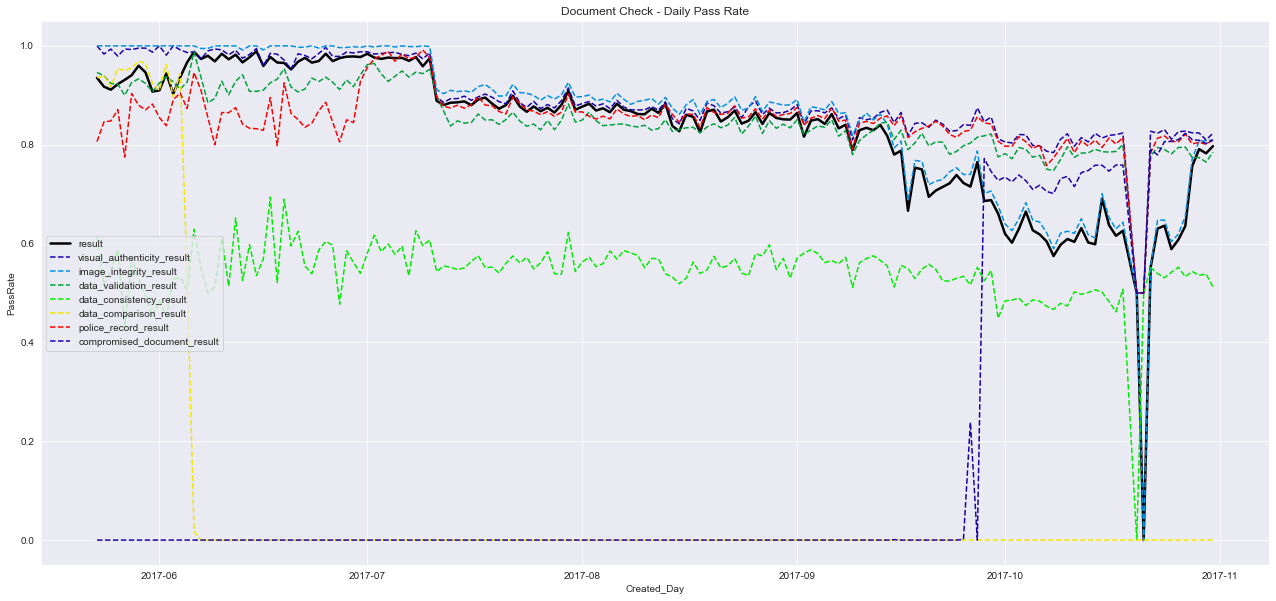

In [14]:
sns.set_palette(palette="nipy_spectral")

results_columns = ['result',
                   'visual_authenticity_result', 'image_integrity_result',
                   'data_validation_result', 'data_consistency_result', 'data_comparison_result',
                   'police_record_result', 'compromised_document_result']

def root_cause_time_series(dataframe, columns, result, title):
    
    fig = plt.figure(figsize = (22,10))

    for column in columns:

        try:
            df_clear = dataframe.copy()
            df_clear = df_clear[df_clear[column] == 'clear']
            df_clear = df_clear.drop_duplicates(subset=df_clear.columns.difference(['attempt_id', 'created_at']))

            df_notclear = dataframe.copy()
            df_notclear = df_notclear[df_notclear[column] != 'clear']
            df_notclear[column] = 'consider'
            df_notclear = df_notclear.drop_duplicates(subset=df_notclear.columns.difference(['attempt_id', 'created_at']))
        
            df2 = df_clear.append(df_notclear, ignore_index = True)

            df2 = df2.groupby(['Created_Day', column]).size().unstack(fill_value=0).reset_index()

            df2['PassRate'] = df2['clear'] / (df2['clear'] + df2['consider'])
        
        except:
            df_clear = pd.DataFrame(columns = dataframe.columns)
            df2['PassRate'] = 0

        if column == result:
            sns.lineplot(x = df2['Created_Day'], y = df2['PassRate'], label = column, color = 'black', lw = 2.5)
        else:
            sns.lineplot(x = df2['Created_Day'], y = df2['PassRate'], label = column, linestyle='--')

    plt.title(title)
    plt.show()
    
    
root_cause_time_series(doc, results_columns, 'result', 'Document Check - Daily Pass Rate')

### Seems like the image_integrity_results is driving the trends of the ultimate result

Let's get rid of the noise to confirm:

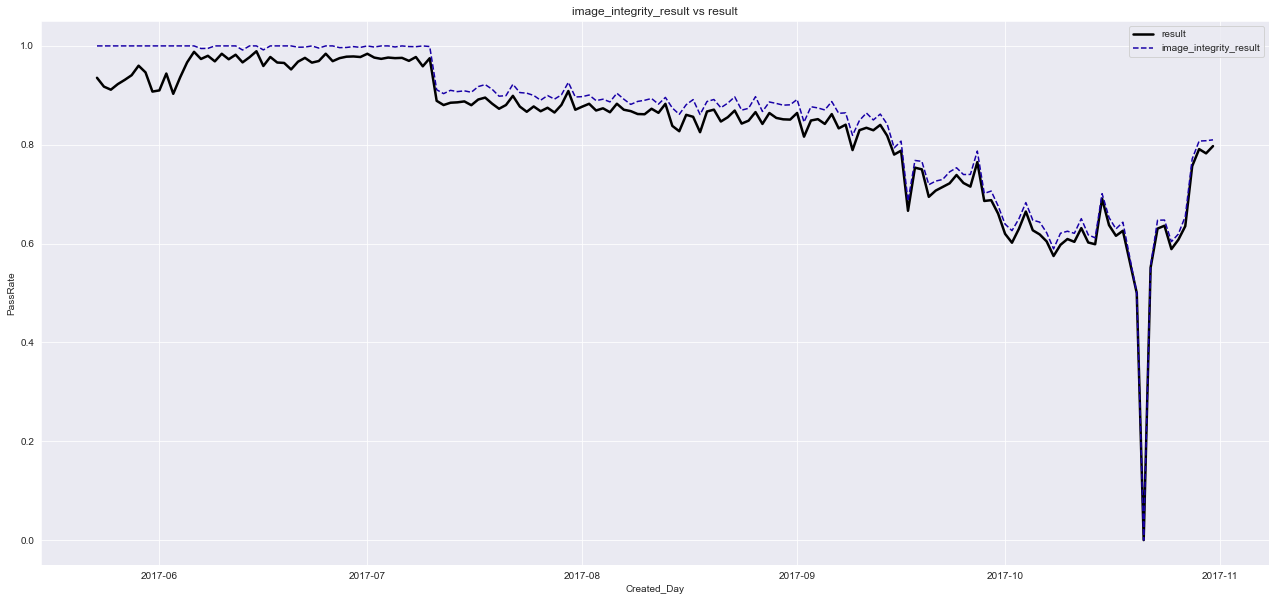

In [15]:
results_columns = ['result', 'image_integrity_result']

root_cause_time_series(doc, results_columns, 'result', 'image_integrity_result vs result')

image_integrity_result results from the results of the following tests:
* **supported_document**
* **image_quality**
* **colour_picture**
* **conclusive_document_quality**

Therefore, the same analysis is performed for these tests, against image_integrity_result:

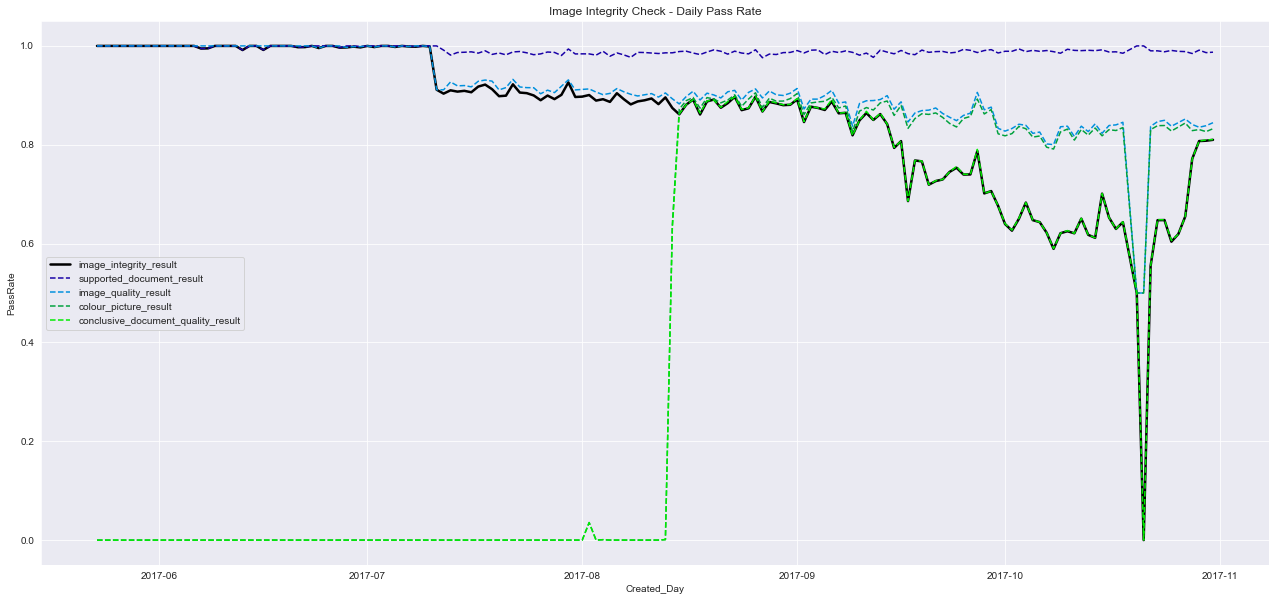

In [16]:
results_columns = ['image_integrity_result', 'supported_document_result', 'image_quality_result', 'colour_picture_result', 'conclusive_document_quality_result']

root_cause_time_series(doc, results_columns, 'image_integrity_result', 'Image Integrity Check - Daily Pass Rate')

## The Conclusive Document Quality Check, released into production around mid August, is definitely the root cause for the recent decrease in the Image Integrity Pass Rate, as it completely overlaps with it.

This perfect overlap means that the image_integrity daily pass rate is being constrained by the results in the conclusive_document_quality, since all other checks have higher pass rates than them. 

Also, since all other checks remained constant (except for the october spike), this means that **the Conclusive Document Quality Check is the only root cause for the decrease in the Image Integrity Pass Rate**. This does not mean, however, that it is the only root cause for the decrease in the **ultimate** pass rate. As we've seen above, other tests have had decreasing trends as well. Nevertheless, it is definitely the main root cause for it.

Alright, we now know what caused the decrease in the ultimate pass rate from around mid september. Since the Conclusive Document Quality Check wasn't around before August though, it doesn't explain the drop in mid July. From the results above, we are able to remove the noise features and focus on the ones that follow similar trends around that date:

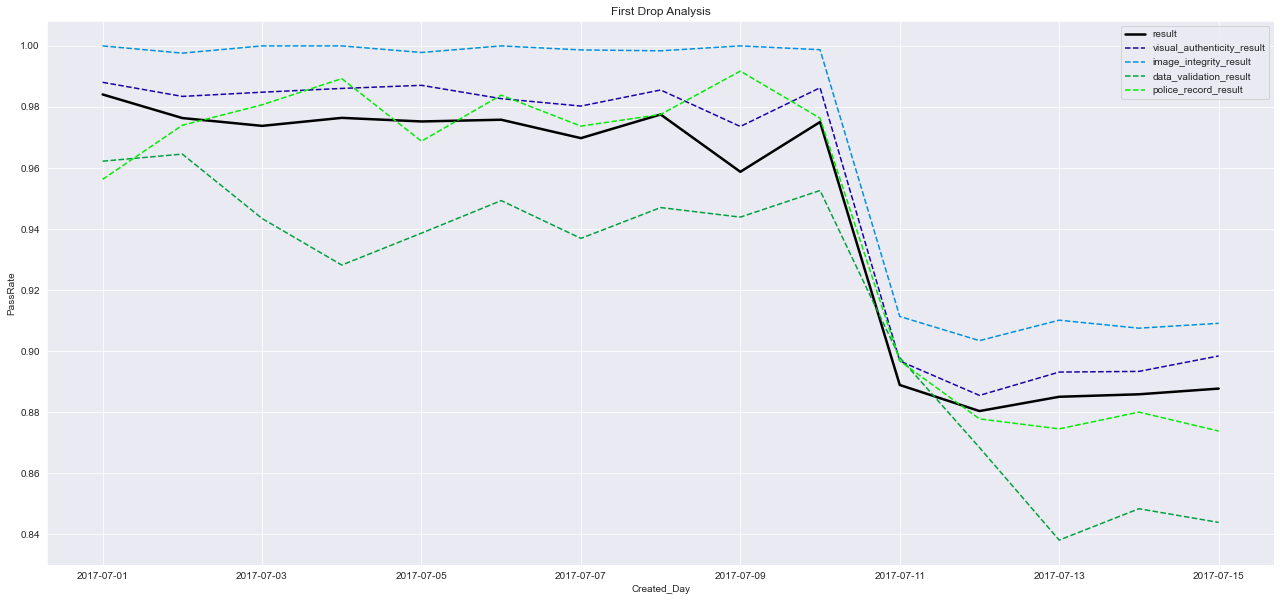

In [17]:
results_columns = ['result',
                   'visual_authenticity_result', 'image_integrity_result',
                   'data_validation_result',
                   'police_record_result']

doc_firstdrop = doc.copy()
doc_firstdrop = doc_firstdrop[doc_firstdrop['Created_Day'] >= datetime.date(2017, 7, 1)]
doc_firstdrop = doc_firstdrop[doc_firstdrop['Created_Day'] <= datetime.date(2017, 7, 15)].reset_index(drop = True)

root_cause_time_series(doc_firstdrop, results_columns, 'result', 'First Drop Analysis')

All of them seem strongly correlated with the final result. However, **the data_validation_result seems to react to the drop, instead of causing it**.

Furthermore, **the Police Record test can't be _clear_ if the document is not properly read**, therefore it seems to show a decrease by consequence, instead of as a cause of the ultimate pass rate decrease.

We will therefore **remove these variables from analysis**.

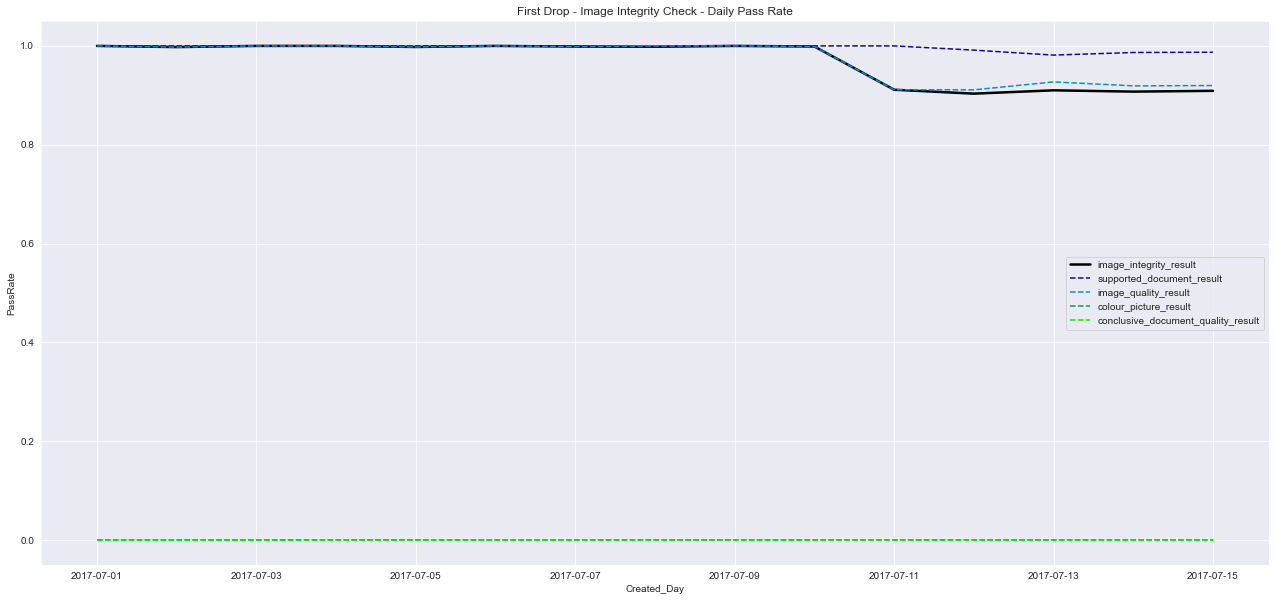

In [18]:
results_columns = ['image_integrity_result', 'supported_document_result', 'image_quality_result', 'colour_picture_result', 'conclusive_document_quality_result']

root_cause_time_series(doc_firstdrop, results_columns, 'image_integrity_result', 'First Drop - Image Integrity Check - Daily Pass Rate')

Colour Picture and Conclusive Document Quality tests were not yet in production at the time. Furthermore, the Supported Document test seems to keep a high (roughly constant) pass rate even after the drop. Therefore, **the root cause for this drop in the Image Integrity test is the Image Quality test**.

Now checking the Visual Authenticity test:

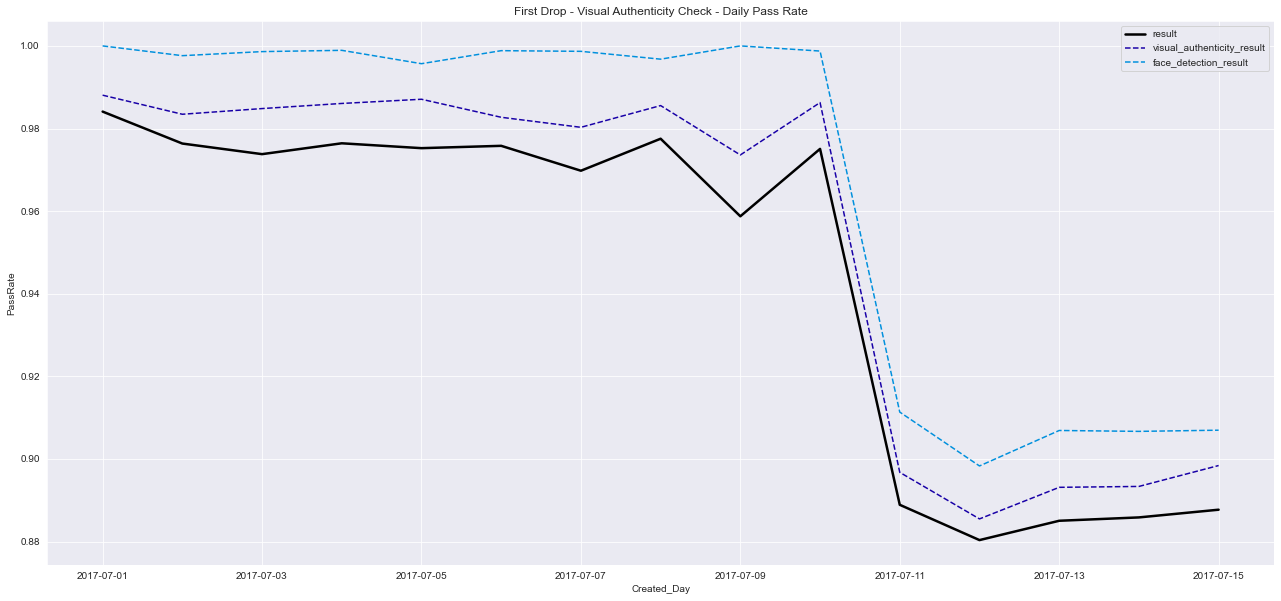

In [19]:
results_columns = ['result', 'visual_authenticity_result', 'face_detection_result']

root_cause_time_series(doc_firstdrop, results_columns, 'result', 'First Drop - Visual Authenticity Check - Daily Pass Rate')

The drops are fairly coincident, therefore one may infer that **the root cause for the Visual Authenticity test is the Face Detection check**. 

The **root causes for the first drop are**, conclusively, the tests of:
* **Face Detection**
* **Image Quality**

According to Veritas API documentation, any data extracted from the document through OCR is returned in the properties attribute. We can then refine our analysis by trying to identify patterns of non-clear customers. For simplification, this analysis will be done for customers who didn't pass the Conclusive Document Quality, since it is the most clear root cause for the descending path of the pass rate:

In [20]:
cdq = doc[doc['conclusive_document_quality_result'] == 'consider'][['attempt_id', 'properties', 'conclusive_document_quality_result']].reset_index(drop=True)
cdq['properties'] = cdq['properties'].map(lambda x: ast.literal_eval(x))
cdq = cdq.join(cdq['properties'].apply(pd.Series))
cdq.drop(columns = ['attempt_id', 'properties', 'conclusive_document_quality_result'], inplace = True)
cdq.head()

,gender,nationality,document_type,date_of_expiry,issuing_country,issuing_date,issuing_state,document_version
0,Male,GBR,passport,2017-06-05,GBR,NaN,NaN,NaN
1,Female,NaN,driving_licence,2025-02-10,GBR,2016-11-15,NaN,NaN
2,Female,NZL,passport,2019-04-03,NZL,NaN,NaN,NaN
3,Male,NaN,national_identity_card,2022-08-06,LTU,NaN,NaN,NaN
4,Male,JPN,passport,2021-02-23,JPN,NaN,NaN,NaN


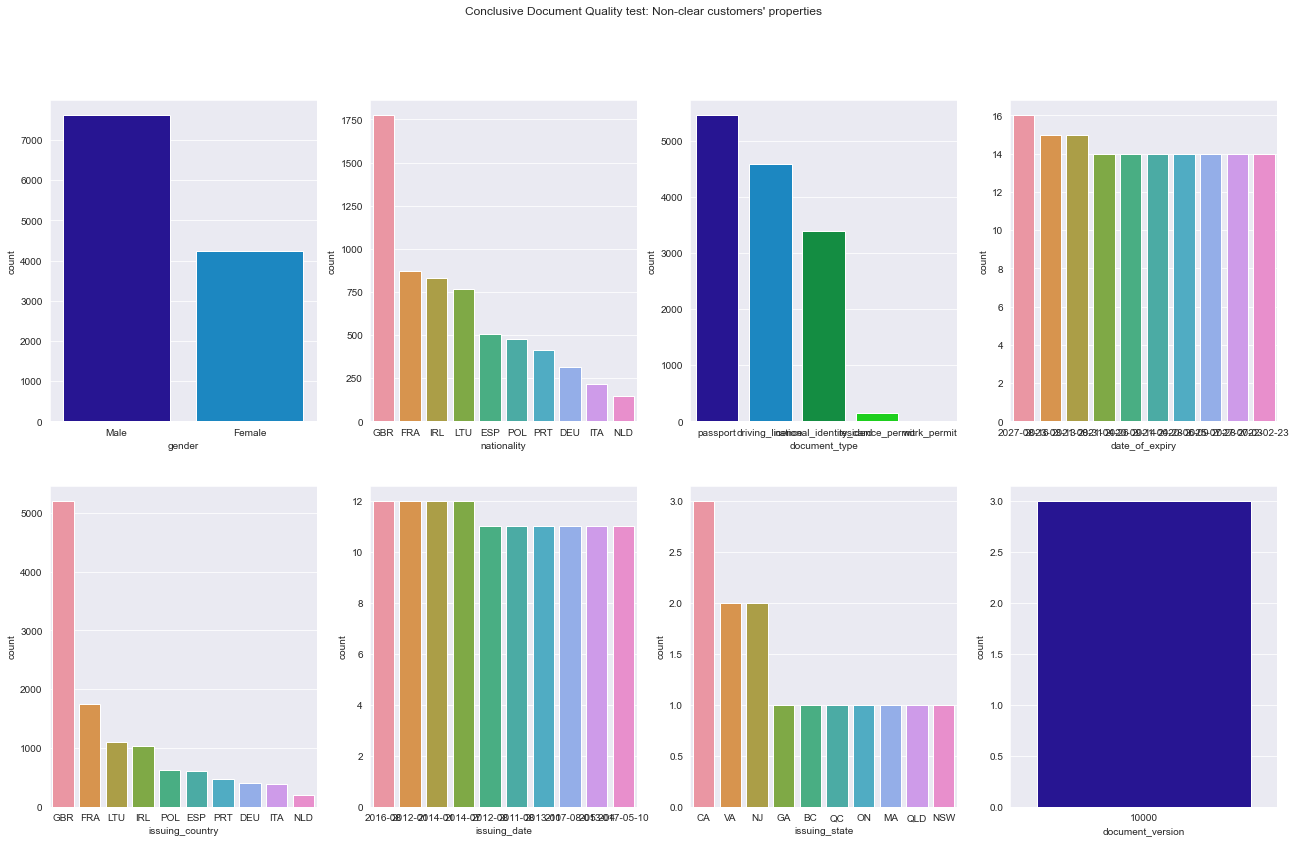

In [51]:
def bar_plot_properties(dataframe, nrows, ncols, title, figsize):

    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    i = 0
    for column in dataframe.columns:

        row = math.floor(i / ncols)
        col = i % ncols
        
        if nrows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        
        sns.countplot(dataframe[column], ax = ax, order=dataframe[column].value_counts().iloc[:10].index)
        
        i += 1
    
    fig.suptitle(title)
    plt.show()
        
bar_plot_properties(cdq, 2, 4, "Conclusive Document Quality test: Non-clear customers' properties", (22, 13))

Appart from Gender, Nationality, Issuing Country and Document Type, the other features exhibit no particular interesting behavior. Therefore, we will focus on these 4:

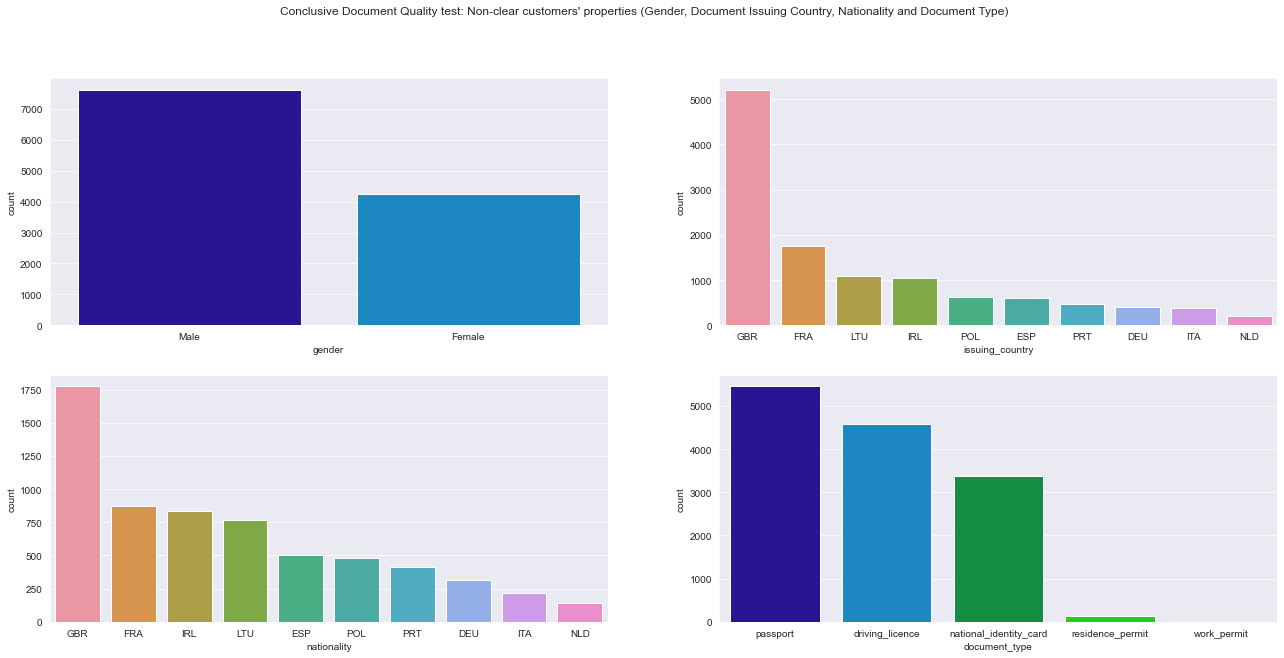

In [58]:
bar_plot_properties(cdq[['gender', 'issuing_country', 'nationality', 'document_type']], 2, 2, \
                    "Conclusive Document Quality test: Non-clear customers' properties (Gender, Document Issuing Country, Nationality and Document Type)", (22, 10))

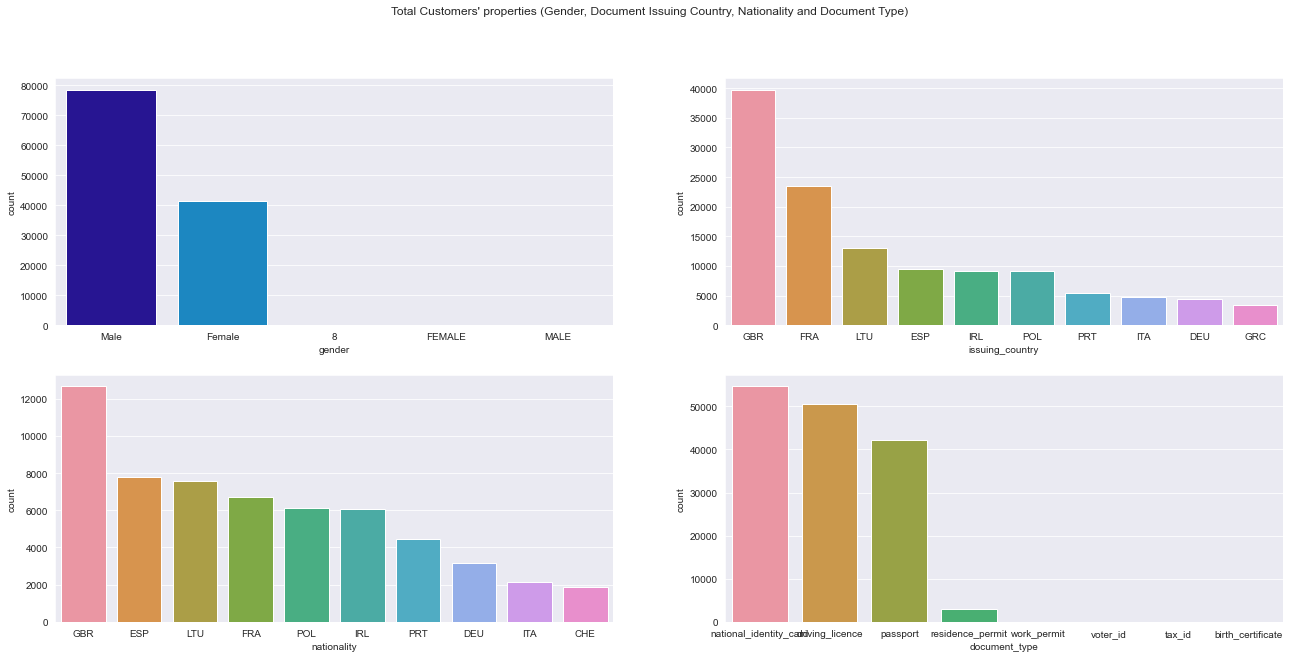

In [59]:
doc2 = doc[['attempt_id', 'properties']].reset_index(drop=True)
doc2['properties'] = doc2['properties'].map(lambda x: ast.literal_eval(x))
doc2 = doc2.join(doc2['properties'].apply(pd.Series))

bar_plot_properties(doc2[['gender', 'issuing_country', 'nationality', 'document_type']], 2, 2, \
                    "Total Customers' properties (Gender, Document Issuing Country, Nationality and Document Type)", (22, 10))

While the differences are not extraordinary, we must not disregard two facts:
* CQD non-clear british customers are in a greater proportion than in the population;
* While passport documents are only ranked 3rd in the population, the majority of non-clear CQD customers used his/her passport for his/her registration.

Therefore, an in-depth analysis would be to deep dive into finding if there's any particularity in passports, specially british passports, that make them harder to pass the tests.

## In conclusion, we found 3 main tests causing for the decrease in the pass rate in recent times:
### 1. Conclusive Document Quality
### 2. Face Detection
### 3. Image Quality

According to Veritas API documentation:

"A result of clear in the conclusive_document_quality breakdown of image_integrity will assert if the document was of enough quality to be able to perform a fraud inspection. A result of consider will mean that even if sub breakdowns of visual_authenticity fail, we cannot positively say the document is fraudulent or not (in cases such as parts of the document are not visible)."

**In the end, it all points out to the difficulty of interpreting visual data of our customers as the main root cause for the problem**.

A sophisticated solution would be to improve and optimize our AI algorithms to better handle peculiarities in the visual input. However, simplicity is key, and a far more advisable approach would be to first sensitize our customers to the need of being cautious when inputting their visual data.

For this to be done well, a thorough analysis on these tests shall be performed, so we can know if these difficulties are due to the lack of light or bad camera positioning, for instance. When these answers arise, we can simultaneously improve our algorithms to better adapt to these irregularities, and prompt the user with custom message asking him/her to be careful with these aspects of the image.